# Anexo 2 - SALT

SALT es un framework de segmentación que se puede utilizar para  tareas de segmentación 2D o 3D. Proporciona un modelo previamente entrenado para la segmentación de 145 estructuras diferentes en el cuerpo humano.

**Conclusiones:** no funciona bien para la segmentación de mandíbula y dientes, porque no tiene clases tan específicas, sino huesos, órganos y tejidos. Se utilizó el modelo para predecir las etiquetas y los resultados visualmente están muy lejos del nivel óptimo.

### 0. Enlaces de interes

1. Readme SALT https://github.com/UMEssen/SALT/blob/main/README.md

## 1.  Instalaciones necesarias

In [ ]:
%%capture
#!pip install monai
!pip install --upgrade monai

In [ ]:
%%capture
!pip install SimpleITK

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import sys
import os

import logging
import pickle
import time
from argparse import ArgumentParser, Namespace
from functools import partial
from pathlib import Path
import SimpleITK as sitk

import numpy as np
import pandas as pd
import torch
from monai.transforms.utils import allow_missing_keys_mode
from matplotlib.colors import ListedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_modified_folders='/content/drive/MyDrive/saros/SALT/modified_files'
dir_pickl = dir_modified_folders + "/config.pkl"
dir_model = dir_modified_folders + "/model.pt"

output_dir = "/content/drive/MyDrive/saros/SALT/labels_predicted/"
dir = '/content/drive/MyDrive/saros/SALT'
data_dir =  dir + '/test/images/'
FOLDER_LABELS_TEST_GT = dir + '/test/labels/'


In [ ]:
sys.path.append(dir_modified_folders)  # Replace with the actual path
from salt_input_pipeline import IntensityProperties, get_postprocess_transforms, get_validation_transforms
from salt_utils_inference import sliding_window_inference_with_reduction

### 2. EDA y requesitos SALT

Requisitos de SALT:

1. Se ejecuta montando una imagen Docker y es obligatorio tener una GPU NVIDIA. En mi caso, no funcionó porque no tengo GPU, por lo tanto, reescribí algunos ficheros con módulos (están guardados en la carpeta SALT/modified_files) para ejecutar la predicción en Google Colab. Dificultades: está escrito en PyTorch y no tengo los conocimientos necesarios.

2. Las imágenes de entrada deben tener formato channel first; en mi caso, utilizo imágenes sin canal, por lo tanto, debí añadir un squeeze(0) adicional a la función main en la parte inputs=example["image"].unsqueeze(0).unsqueeze(0).cuda().

3. Las carpetas deben tener la estructura específica según lo descrito en los enlaces de interés.

Las imágenes de entrada deben tener formato channel first; en mi caso, utilizo imágenes sin canal (410, 410):

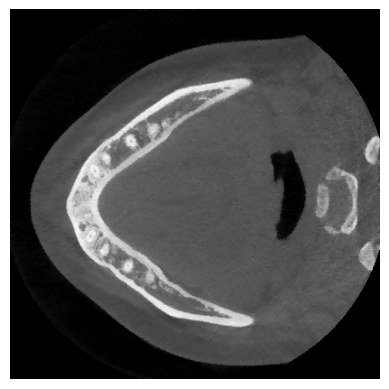

(410, 410)
(410, 410)


In [ ]:
# Imagen de entrada
imagen = nib.load(data_dir + "ToothFairy2F_052200_0000.nii.gz")
datos= imagen.get_fdata()
plt.imshow(datos,cmap='gray')
plt.axis("off")
plt.show()
print(imagen.shape)
print(datos.shape)

## Predicción utilizando conjunto de test

### 4.1 Inferencia

Codigo de predict.py modificado

In [ ]:
logger = logging.getLogger(__name__)


def argmax_leaves(
    inputs: torch.Tensor,
    adjacency_matrix: np.ndarray,
    dim: int = 1,
    pruned: bool = True,
) -> torch.Tensor:
    leave_nodes = np.where(adjacency_matrix[1:, 1:].sum(axis=1) == 0)[0]
    indices = np.arange(adjacency_matrix.shape[0] - 1, dtype=np.int32)
    indices = indices[leave_nodes]
    y_pred_leaves = inputs[:, leave_nodes]
    y_pred_leave_idx = torch.argmax(y_pred_leaves, axis=dim)
    if pruned:
        return y_pred_leave_idx
    return torch.tensor(indices).to(inputs.device)[y_pred_leave_idx]


def main(args: Namespace) -> None:
    logger.info("Loading model...")
    with (args.config_file).open(
        "rb",
    ) as ifile:
        config = pickle.load(ifile)

    model = torch.jit.load(args.model_file)

    pre_processing = get_validation_transforms(
        spacing=config["model"]["voxel_spacing"],
        info=None,
        intensity_properties=(
            IntensityProperties(
                mean=config["intensity_properties"]["mean"],
                std=config["intensity_properties"]["std"],
            )
            if config["intensity_properties"] is not None
            else None
        ),
    )
    model.cuda()
    model.eval()

    # HACK Disable JIT profiling to speed up first inference rounds
    # See: https://github.com/pytorch/pytorch/issues/52286
    torch._C._jit_set_profiling_executor(False)

    if args.data_dir.is_dir():
        inputs = sorted(args.data_dir.glob("*.nii.gz"))
    else:
        inputs = [args.data_dir]
    times = []
    for i, input_path in enumerate(inputs, start=1):
        logger.info(f"{i}/{len(inputs)}: Loading image {input_path.name}...")
        with allow_missing_keys_mode(pre_processing):
            example = pre_processing({"image": input_path})
        logger.info(f"Computing model output for {input_path.name}...")
        base_dict = {"image": input_path.name.replace(".nii.gz", "")}
        start = time.time()
        with torch.cuda.amp.autocast(), torch.no_grad():
            print(example["image"].shape)
            pred = (
                sliding_window_inference_with_reduction(
                    inputs=example["image"].unsqueeze(0).unsqueeze(0).cuda(),     #inputs=example["image"].unsqueeze(0).unsqueeze(0).cuda()
                    roi_size=config["model"]["roi_size"],
                    sw_batch_size=2,
                    predictor=model,
                    progress=True,
                    overlap=0.5,
                    mode="gaussian",
                    cval=(
                        (-1024 - config["intensity_properties"]["mean"])
                        / config["intensity_properties"]["std"]
                        if config["intensity_properties"] is not None
                        else 0.0
                    ),
                    reduction_fn=partial(
                        argmax_leaves, adjacency_matrix=config["adjacency_matrix"]
                    ),
                    # device="cpu",
                )
                .cpu()
                .to(torch.int64)
            )
        base_dict["prediction_time"] = time.time() - start
        logger.info("Applying post-processing and saving image")
        postprocess_time = time.time()
        pred = get_postprocess_transforms(output_dir=args.output_dir)(
            #{"pred": pred, "image_meta_dict": example["image_meta_dict"]}
            {"pred": pred}
        )
        base_dict["postprocess_time"] = time.time() - postprocess_time
        base_dict["total_time"] = time.time() - start
        base_dict["shape"] = tuple(pred["pred"][0].shape)
        times.append(base_dict)
    pd.DataFrame(times).to_csv(args.output_dir / "times.csv", index=False)



args = Namespace(
    model_file=Path(dir_model),       #("/content/model.pt"),
    config_file=Path(dir_pickl),
    data_dir=Path(data_dir),
    output_dir=Path(output_dir),
)

# Llamar a la función principal
main(args)

/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('LPI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (410, 410), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(


torch.Size([1, 274, 274])


100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

2024-06-05 08:46:40,501 INFO image_writer.py:197 - writing: /content/drive/MyDrive/saros/SALT/labels_predicted/ToothFairy2F_052200_0000/ToothFairy2F_052200_0000_pred.nii.gz


### 4.2. Resultados de test

In [ ]:
def show_two_nii_images(file_name1, file_name2, file_name3, ruta_imagen_test, ruta_label_test, ruta_label_predicho):
    """
    Muestra dos imágenes .nii.gz en una sola línea.

    Args
        file_name1 (str): imagen de test.nii.gz (sin ruta).
        file_name2 (str): label de test .nii.gz (sin ruta).
        file_name3 (str): label predicho .nii.gz (sin ruta).
        slice_index (int): Índice de la slice a mostrar (por defecto es 0).
    """
    # Directorios predeterminados
    image_dir1 = ruta_imagen_test
    image_dir2 = ruta_label_test
    image_dir3 = ruta_label_predicho

    # Construir las rutas completas de los archivos
    image_path1 = os.path.join(image_dir1, file_name1)
    image_path2 = os.path.join(image_dir2, file_name2)
    image_path3 = os.path.join(image_dir3, file_name3)

    print(image_path1)
    print(image_path2)
    print(image_path3)

    # Leer imágenes
    image1 = sitk.ReadImage(image_path1)
    image2 = sitk.ReadImage(image_path2)
    image3 = sitk.ReadImage(image_path3)

    # Convertir las imágenes a arrays numpy y reformatear
    image_array1 = sitk.GetArrayFromImage(image1)
    image_array2 = sitk.GetArrayFromImage(image2)
    image_array3 = sitk.GetArrayFromImage(image3)


    # Colores distintivos para las clases originales
    color_map_dict = ['black', 'red', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange',
                  'green', 'green', 'green', 'green', 'green', 'green', 'green',
                  'orange', 'orange', 'orange',
                  'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green',
                  'orange', 'orange',
                  'green', 'green', 'green', 'green', 'green', 'green', 'green',
                  'orange', 'orange', 'orange', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green']
    cmap_original = ListedColormap(color_map_dict)

    # Mostrar las imágenes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusta el tamaño de la figura
    plt.subplots_adjust(wspace=0.3)  # Ajusta el espaciado entre subgráficos

    # Primera imagen
    axes[0].imshow(image_array1, cmap='gray')  # Muestra la imagen en escala de grises
    axes[0].set_title('Imagen de Test')

    # Segunda imagen
    axes[1].imshow(image_array2,cmap = "turbo" )  # Muestra la imagen de label de test
    axes[1].set_title('Etiqueta original')

    # Tercera imagen
    im = axes[2].imshow(image_array3,cmap = "turbo" )  # Muestra la imagen de label predicho
    axes[2].set_title('Etiqueta predicha')

    plt.show()

/content/drive/MyDrive/saros/SALT/test/images/ToothFairy2F_052200_0000.nii.gz
/content/drive/MyDrive/saros/SALT/test/labels/ToothFairy2F_052200.nii.gz
/content/drive/MyDrive/saros/SALT/labels_predicted/ToothFairy2F_052200_0000/ToothFairy2F_052200_0000_pred.nii.gz


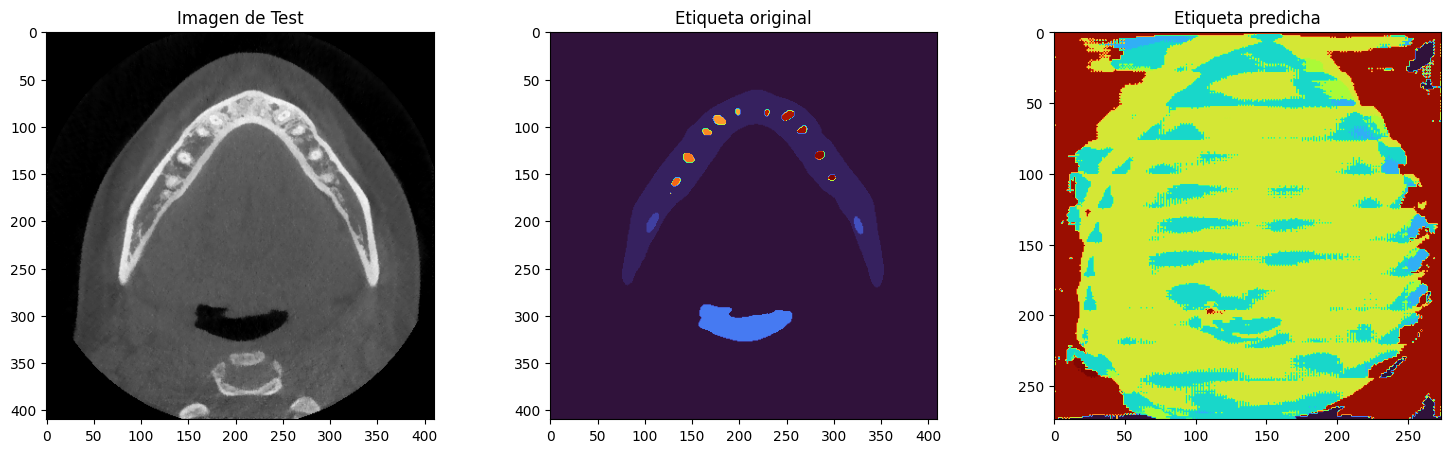

In [ ]:
# Ejemplo de uso de la función
file_name1 = 'ToothFairy2F_052200_0000.nii.gz'
file_name2 = 'ToothFairy2F_052200.nii.gz'
file_name3 = 'ToothFairy2F_052200_0000_pred.nii.gz'
show_two_nii_images(file_name1, file_name2, file_name3, data_dir, FOLDER_LABELS_TEST_GT, "/content/drive/MyDrive/saros/SALT/labels_predicted/ToothFairy2F_052200_0000/")